In [1]:
from os import makedirs, path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler # StandardScaler

<h3> 視覺畫圖表函數 </h3>

In [2]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # Windows 常見字體
plt.rcParams['axes.unicode_minus'] = False  # 解決座標軸負號顯示問題

In [3]:
makedirs('feature', exist_ok=True)

In [4]:
# 使用 箱線圖 來檢查特徵中的異常值。
def visualize_outliers(data, save=False, bound_text=False):
    
    '''
    繪製箱線圖（Box Plot），可視化異常值。
    '''
    
    # 1. 提取特徵列
    plot_cols = ['turbidity', 'disolved_oxg', 'ph', 'ammonia', 'nitrate', 'fish_weight']  # 提取指定的特徵

    # 2. 定義顏色，與特徵列對應
    colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'deeppink']

    # 3. 動態計算子圖佈局
    n_features = len(plot_cols)  # 特徵數量
    ncols = 2  # 每行顯示 3 個子圖
    nrows = (n_features + ncols - 1) // ncols  # 計算需要的行數（向上取整）

    # 4. 創建子圖
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))  # 動態設置子圖大小
    axs = axs.flatten()  # 將子圖矩陣展平成一維數組，方便索引
    fig.subplots_adjust(wspace=0.4, hspace=0.5)  # 調整子圖間距
    
    # 5. 繪製每個特徵的箱線圖
    for i, col in enumerate(plot_cols):
        axs[i].boxplot(data[col], patch_artist=True, boxprops=dict(facecolor=colors[i % len(colors)], alpha=0.6))
        axs[i].set_title(col, fontsize=12)  # 設置每個箱線圖的標題
        axs[i].set_ylabel("值", rotation=0)  # y 軸標籤
        axs[i].set_xticks([])  # 隱藏 y 軸刻度
        axs[i].set_xlabel(f"{col}", rotation=0) # x 軸標籤

        if bound_text:
                # 計算上下四分位數和鬍鬚的數值
            Q1 = np.percentile(data[col], 25)  # 下四分位數
            Q3 = np.percentile(data[col], 75)  # 上四分位數
            IQR = Q3 - Q1  # 四分位距
            lower_bound = Q1 - 1.5 * IQR  # 下鬍鬚
            upper_bound = Q3 + 1.5 * IQR  # 上鬍鬚
                # 標註上下邊緣值
            axs[i].text(1.1, lower_bound, f"{col} Lower: {lower_bound:.2f}", color='blue', fontsize=10, ha='left')
            axs[i].text(1.1, upper_bound, f"{col} Upper: {upper_bound:.2f}", color='red', fontsize=10, ha='left')


    # 顯示圖表
    plt.tight_layout()
    if save:
        plt.savefig('feature/IoTpond3 Features Outlier Detection.png', bbox_inches='tight') # 儲存圖表，並且自動調整圖表的邊界，去除多餘的空白區域。
    plt.show()
    

In [5]:
# 使用 分佈圖 來檢查特徵中的異常值。
def visualize_distributions(data, save=False):
    
    '''
    繪製分佈圖，可視化異常值。
    '''
    
    plot_cols = ['turbidity', 'disolved_oxg', 'ph', 'ammonia', 'nitrate', 'fish_weight']  # 提取指定的特徵
    n_features = len(plot_cols)
    ncols = 2
    nrows = (n_features + ncols - 1) // ncols

    # 創建子圖
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axs = axs.flatten() # 將子圖展平成一維陣列
    fig.subplots_adjust(wspace=0.4, hspace=0.5) # 調整子圖間距

    # 遍歷每個特徵，繪製直方圖
    for i, col in enumerate(plot_cols):
        sns.histplot(data[col], kde=True, ax=axs[i], color='orange', alpha=0.5)  # 繪製直方圖和 KDE 曲線
        axs[i].tick_params(axis='x', labelsize=10)  # # 設置 x 軸刻度和標籤大小。
        axs[i].set_title(col, fontsize=12) # 設置標題。

    # 顯示圖表
    plt.tight_layout()
    if save:
        plt.savefig('feature/IoTpond3 Features Distributions.png', bbox_inches='tight') # 儲存圖表，並且自動調整圖表的邊界，去除多餘的空白區域。
    plt.show()
    

In [6]:
# 將多個特徵（列）的數據繪製成子圖，並基於提供的日期時間索引進行繪製。
def visualize_df(data, date_times, save=False): 
    '''
    將多個特徵列在子圖中進行時間序列可視化。
    '''
    # 1. 提取數據和時間索引
    df = data
    date_time = date_times
    plot_cols = df.columns # 提取列名（特徵名）

    # 2. 定義顏色，與特徵列對應
    colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'deeppink']

    # 3. 設置繪圖特徵和時間索引
    plot_features = df[plot_cols] # 選擇所有特徵列
    plot_features.index = date_time # 將日期時間設為索引，方便繪圖

    # 4. 創建子圖
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10)) # 3 行 2 列的子圖佈局
    fig.subplots_adjust(wspace=0.1, hspace=0.2) # 調整子圖之間的間距
    
     # 5. 遍歷每個特徵，並繪製到對應的子圖中
    for i, col in enumerate(plot_features): # 遍歷每個特徵（列名）
        row_idx = i // 2 # 確定當前特徵位於哪一行
        col_idx = i % 2  # 確定當前特徵位於哪一列
        axs[row_idx, col_idx].plot(plot_features[col], color=colors[i], label=col) # 繪製該特徵的數據
        axs[row_idx, col_idx].tick_params(axis='x', labelsize=7) # 指定顏色
        axs[row_idx, col_idx].legend() # 設置圖例為列名

    # 6. 顯示圖表
    plt.tight_layout()
    if save:
        plt.savefig('feature/IoTpond3 Features Analysis.png', bbox_inches='tight') # 儲存圖表，並且自動調整圖表的邊界，去除多餘的空白區域。
    plt.show()
    

In [7]:
# 繪製時間序列數據及其異常值（outliers）的函數。
def plot_outlier(ts, n_column, ewm_span=100, threshold=3.0, save=False):
    '''
    利用 指數加權移動平均（EWMA） 來檢測異常。
    1.) ts：需要檢測異常值的時間序列資料，應該是 pandas.Series 型態。
    2.) n_column：圖表的標題，通常是欄位名稱，用來指明是哪個特徵（feature）。
    3.) ewm_span：控制指數加權移動平均的平滑度，越高的值使平滑效果越強（默認為 100）。
    4.) threshold：異常值的檢測閾值，以標準差為單位，默認為 3.0，即數值偏離均值超過 3 個標準差會被認為是異常值。
    '''
    assert type(ts) == pd.Series # 確保 ts 是一個 pandas.Series 型態，否則會報錯。
    fig, ax = plt.subplots(figsize=(15,5)) # 建立圖表，並設置圖表大小為 15x5。
    ewm_mean = ts.ewm(span=ewm_span).mean()  # 計算時間序列的指數加權移動平均值（EWMA）。
    ewm_std = ts.ewm(span=ewm_span).std()  # 計算時間序列的指數加權標準差，用來判斷異常值。
    ax.plot(ts, label='original') # 繪製原始時間序列數據。
    ax.plot(ewm_mean, label='ewma') # 繪製指數加權移動平均線，提供平滑的數據趨勢。

    # plot data which deviate from range during mean ±  3 * std as outlier 
    ax.fill_between(ts.index,
                    ewm_mean - ewm_std * threshold,
                    ewm_mean + ewm_std * threshold,
                    alpha=0.2) # 填充一個區域，範圍為平均值加減 3 倍標準差（可以根據 threshold 調整），用來表示「正常區域」。位於此區域外的數據將視為異常值。
    outlier = ts[(ts - ewm_mean).abs() > ewm_std * threshold] # 篩選出超出正常區域的異常值。
    ax.scatter(outlier.index, outlier, label='outlier') # 使用散點圖標記異常值的位置。
    ax.legend() # 添加圖例，標示出原始數據、移動平均線和異常值。
    plt.title(n_column) # 設置圖表標題為指定的欄位名稱（n_column）。
    if save:
        plt.savefig(f'feature/{n_column}.png') # 儲存圖表
    plt.show()


<h3> Start IoTPond3 </h3>

In [8]:
# 讀取數據
df = pd.read_csv('IoTPond3.csv')
df

,created_at,entry_id,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,population,fish_length,fish_weight
0,2021-06-19 00:00:04 CET,1941,23.7500,80,27.736,7.04911,5.15546,114,50,6.74,3.20
1,2021-06-19 00:00:26 CET,1942,23.7500,80,4.195,7.09450,4.53072,114,50,6.74,3.20
2,2021-06-19 00:02:03 CET,1945,23.7500,80,10.310,7.07635,5.21473,113,50,6.74,3.20
3,2021-06-19 00:02:26 CET,1946,23.7500,81,1.196,7.07181,5.41747,100,50,6.74,3.20
4,2021-06-19 00:03:31 CET,1948,23.7500,80,2.338,7.08996,5.45899,112,50,6.74,3.20
...,...,...,...,...,...,...,...,...,...,...,...
169180,2021-10-12 15:04:28 CET,172697,25.6875,100,5.080,1.52004,0.00000,302,50,33.00,294.92
169181,2021-10-12 15:04:48 CET,172698,25.6600,100,5.080,1.43379,0.00000,285,50,33.00,294.92
169182,2021-10-12 15:05:07 CET,172699,25.3750,100,5.080,1.28853,0.00000,299,50,33.00,294.92
169183,2021-10-12 15:05:27 CET,172700,25.4375,100,5.080,1.14327,0.00000,282,50,33.00,294.92


<p> Note: 欄位代表的意思 </p>
<ol>
    <li>created_at:資料記錄的時間戳，表示數據被收集的時間。</li>
    <li>entry_id:每條數據記錄的唯一標識符，用於區分不同的數據記錄。不直接影響分析。</li>
    <li>temperature:水溫，表示魚塘的水溫（攝氏）。</li>
    <li>turbidity:渾濁度，表示水的透明程度或清澈程度。</li>
    <li>disolved_oxg:溶解氧濃度，表示水中溶解氧的含量（mg/L）。</li>
    <li>ph:水的酸鹼度。</li>
    <li>ammonia:氨濃度，表示水中氨的濃度。</li>
    <li>nitrate:硝酸鹽濃度，表示水中的硝酸鹽含量。</li>
    <li>population:魚塘中的魚類數量。</li>
    <li>fish_length:魚的平均長度（單位：厘米）。</li>
    <li>fish_weight:魚的平均重量（單位：克）。</li>
</ol>

In [9]:
df['entry_id'].nunique()
df['created_at'].nunique()

169185

In [10]:
# 將created_at設為index
df["created_at"] = pd.to_datetime(df["created_at"].str.replace(" CET", ""), format="%Y-%m-%d %H:%M:%S") # %Z
df = df.sort_values('created_at') # 依時間進行排序。
df.set_index('created_at', inplace=True) # 將測量日期與時間設為index。
df

,entry_id,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,population,fish_length,fish_weight
created_at,,,,,,,,,,
2021-06-19 00:00:04,1941,23.7500,80,27.736,7.04911,5.15546,114,50,6.74,3.20
2021-06-19 00:00:26,1942,23.7500,80,4.195,7.09450,4.53072,114,50,6.74,3.20
2021-06-19 00:02:03,1945,23.7500,80,10.310,7.07635,5.21473,113,50,6.74,3.20
2021-06-19 00:02:26,1946,23.7500,81,1.196,7.07181,5.41747,100,50,6.74,3.20
2021-06-19 00:03:31,1948,23.7500,80,2.338,7.08996,5.45899,112,50,6.74,3.20
...,...,...,...,...,...,...,...,...,...,...
2021-10-12 15:04:28,172697,25.6875,100,5.080,1.52004,0.00000,302,50,33.00,294.92
2021-10-12 15:04:48,172698,25.6600,100,5.080,1.43379,0.00000,285,50,33.00,294.92
2021-10-12 15:05:07,172699,25.3750,100,5.080,1.28853,0.00000,299,50,33.00,294.92


In [11]:
# Dropping the unnecessary columns
columns_to_drop = ['entry_id', 'population']  
df = df.drop(columns=columns_to_drop)
df

,temperature,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_length,fish_weight
created_at,,,,,,,,
2021-06-19 00:00:04,23.7500,80,27.736,7.04911,5.15546,114,6.74,3.20
2021-06-19 00:00:26,23.7500,80,4.195,7.09450,4.53072,114,6.74,3.20
2021-06-19 00:02:03,23.7500,80,10.310,7.07635,5.21473,113,6.74,3.20
2021-06-19 00:02:26,23.7500,81,1.196,7.07181,5.41747,100,6.74,3.20
2021-06-19 00:03:31,23.7500,80,2.338,7.08996,5.45899,112,6.74,3.20
...,...,...,...,...,...,...,...,...
2021-10-12 15:04:28,25.6875,100,5.080,1.52004,0.00000,302,33.00,294.92
2021-10-12 15:04:48,25.6600,100,5.080,1.43379,0.00000,285,33.00,294.92
2021-10-12 15:05:07,25.3750,100,5.080,1.28853,0.00000,299,33.00,294.92


<h3> 「養殖優化」，利用 "可控變數" 進行預測。 </h3>

<p> 因此剔除不可控變因。 </p>

In [12]:
# Dropping the unnecessary columns
columns_to_drop = ['temperature', 'fish_length']  
df = df.drop(columns=columns_to_drop)
df

,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_weight
created_at,,,,,,
2021-06-19 00:00:04,80,27.736,7.04911,5.15546,114,3.20
2021-06-19 00:00:26,80,4.195,7.09450,4.53072,114,3.20
2021-06-19 00:02:03,80,10.310,7.07635,5.21473,113,3.20
2021-06-19 00:02:26,81,1.196,7.07181,5.41747,100,3.20
2021-06-19 00:03:31,80,2.338,7.08996,5.45899,112,3.20
...,...,...,...,...,...,...
2021-10-12 15:04:28,100,5.080,1.52004,0.00000,302,294.92
2021-10-12 15:04:48,100,5.080,1.43379,0.00000,285,294.92
2021-10-12 15:05:07,100,5.080,1.28853,0.00000,299,294.92


<p> 查看是否有缺失值。 </p>

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169185 entries, 2021-06-19 00:00:04 to 2021-10-12 15:05:46
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   turbidity     169185 non-null  int64  
 1   disolved_oxg  169185 non-null  float64
 2   ph            169185 non-null  float64
 3   ammonia       169078 non-null  float64
 4   nitrate       169185 non-null  int64  
 5   fish_weight   169185 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 9.0 MB


In [14]:
# checking null values in our dataset
df.isna().sum()

turbidity         0
disolved_oxg      0
ph                0
ammonia         107
nitrate           0
fish_weight       0
dtype: int64

<p> ammonia 存在缺失值！ </p>

<h4> 使用 箱線圖 或 分佈圖 來檢查特徵中的異常值。 </h4>

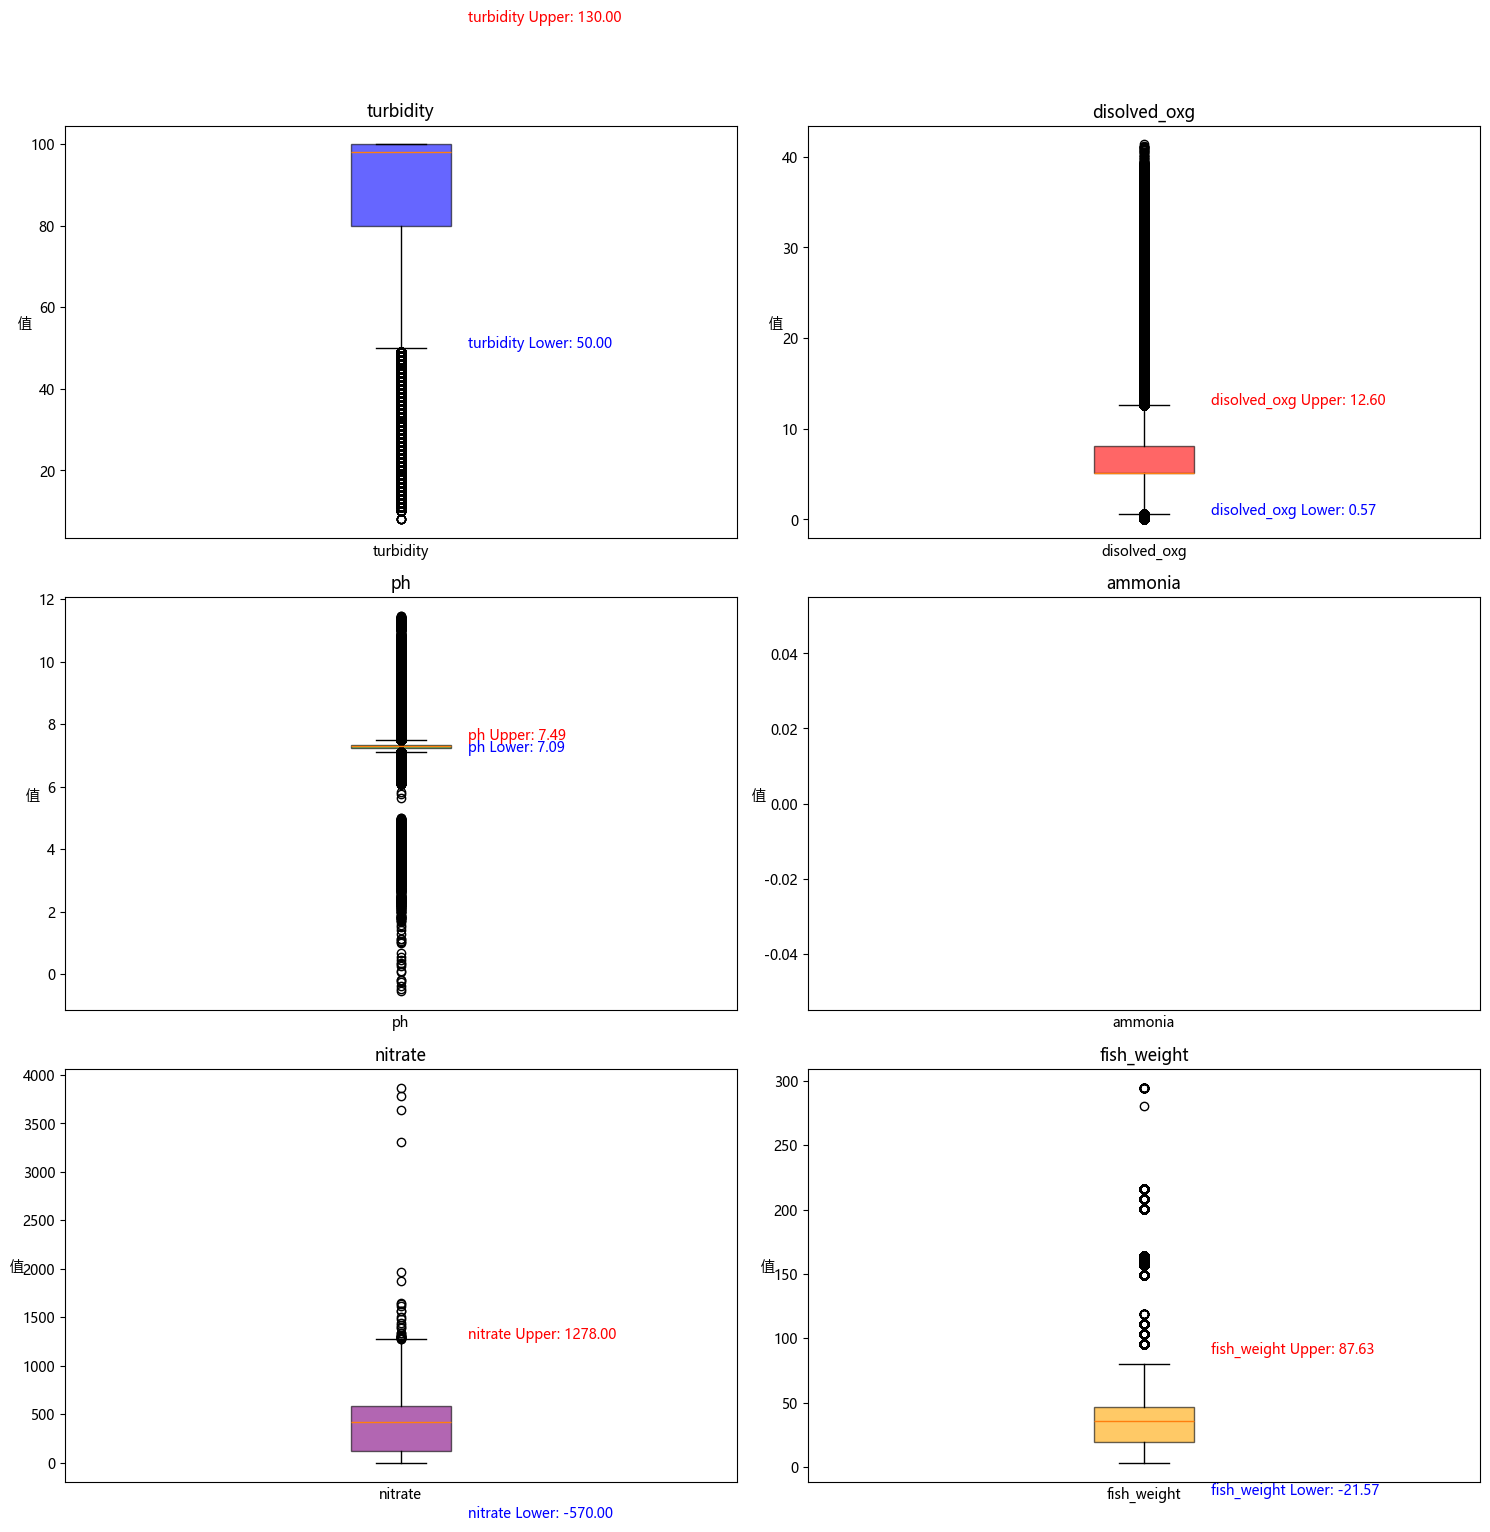

In [15]:
# 使用 箱線圖 來檢查特徵中的異常值。
visualize_outliers(df, bound_text=True)
# visualize_outliers_and_distributions(df) # 使用 分佈圖 來檢查特徵中的異常值。 # MemoryError

<ol> 
    <li> ammonia 包含缺失值，所以箱線圖暫且無法繪製。</li>
    <li> 且temperature有數筆異常值。(-127度) </li>
</ol>

In [16]:
#敘述統計
df.describe().transpose()

C:\Users\HoChePing\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
turbidity,169185.0,83.384898,26.651853,8.0000,80.00000,98.00000,100.00000,100.00000
disolved_oxg,169185.0,7.456181,6.410530,0.0080,5.08000,5.08000,8.08800,41.38400
ph,169185.0,7.184931,0.629428,-0.5318,7.24431,7.30786,7.34417,11.45693
ammonia,169078.0,inf,NaN,0.0000,5.75912,29.42574,1009.76642,inf
nitrate,169185.0,380.670804,255.443631,0.0000,123.00000,417.00000,585.00000,3870.00000
fish_weight,169185.0,44.259006,45.519340,3.2000,19.38000,35.83000,46.68000,294.92000


<p> 並且有異常數據需要處理！ </p>

<h3> 處理缺失值&異常值 </h3>

In [17]:
# 由於IoTPond3資料集中fish_weight沒有缺失值，所以不須執行這段程式碼。
# 刪除 fish_weight 欄位中有缺失值的行
df = df.dropna(subset=['fish_weight'])
df

,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_weight
created_at,,,,,,
2021-06-19 00:00:04,80,27.736,7.04911,5.15546,114,3.20
2021-06-19 00:00:26,80,4.195,7.09450,4.53072,114,3.20
2021-06-19 00:02:03,80,10.310,7.07635,5.21473,113,3.20
2021-06-19 00:02:26,81,1.196,7.07181,5.41747,100,3.20
2021-06-19 00:03:31,80,2.338,7.08996,5.45899,112,3.20
...,...,...,...,...,...,...
2021-10-12 15:04:28,100,5.080,1.52004,0.00000,302,294.92
2021-10-12 15:04:48,100,5.080,1.43379,0.00000,285,294.92
2021-10-12 15:05:07,100,5.080,1.28853,0.00000,299,294.92


<p> temperature </p>

In [ ]:
# temperature或許為不可控變因，因此這邊先暫時略過，不再考慮。
# # 有筆溫度為-127，不合理，刪除該筆資料。刪除不合理的溫度(異常值)。
# df = df[df['temperature'] != -127]
# df

<p> Fish Weight </p>

<ol> Note: 針對目標變數（Fish Weight）去除異常值
    <li> 因為異常值的存在可能會對模型的學習過程產生負面影響，因此針對目標變數（Fish Weight）去除異常值。直接針對目標變數進行優化。 </li>
    <li> 特徵中的異常值並不一定與目標變數直接相關，而是可能存在於數據收集過程中的誤差。 </li>
    <li> 簡化處理，避免過度刪除可能有用的數據點。保留更多數據。 </li>
</ol>

In [18]:
# 對目標變數(Fish Weight)找出異常值並篩除。
Q1 = df['fish_weight'].quantile(0.25) # 第一四分位數
Q3 = df['fish_weight'].quantile(0.75) # 第三四分位數
IQR = Q3 - Q1

# 計算上下界
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 找出異常值
outliers = df[(df['fish_weight'] < lower_bound) | (df['fish_weight'] > upper_bound)]
outliers = outliers.sort_values('fish_weight')
outliers

,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_weight
created_at,,,,,,
2021-08-20 14:51:33,100,0.062,7.27608,0.00534,670,95.56
2021-08-20 19:20:20,100,5.080,7.22161,0.00586,713,95.56
2021-08-20 19:20:00,100,5.080,7.21707,0.00641,704,95.56
2021-08-20 19:17:50,100,5.080,7.22615,0.00638,693,95.56
2021-08-20 19:16:15,100,6.793,7.22615,0.00538,693,95.56
...,...,...,...,...,...,...
2021-10-12 14:11:00,100,5.080,1.58813,0.00000,3783,294.92
2021-10-12 14:10:31,100,5.080,2.01484,0.00005,3870,294.92
2021-10-12 15:05:27,100,5.080,1.14327,0.00000,282,294.92


In [19]:
df = df[(df['fish_weight'] >= lower_bound) & (df['fish_weight'] <= upper_bound)]
df

,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_weight
created_at,,,,,,
2021-06-19 00:00:04,80,27.736,7.04911,5.15546,114,3.20
2021-06-19 00:00:26,80,4.195,7.09450,4.53072,114,3.20
2021-06-19 00:02:03,80,10.310,7.07635,5.21473,113,3.20
2021-06-19 00:02:26,81,1.196,7.07181,5.41747,100,3.20
2021-06-19 00:03:31,80,2.338,7.08996,5.45899,112,3.20
...,...,...,...,...,...,...
2021-08-18 22:03:11,100,5.080,7.21253,0.04318,844,80.14
2021-08-18 22:13:42,100,5.080,7.09450,0.04646,825,80.14
2021-08-18 22:17:44,100,5.080,7.11266,0.04219,800,80.14


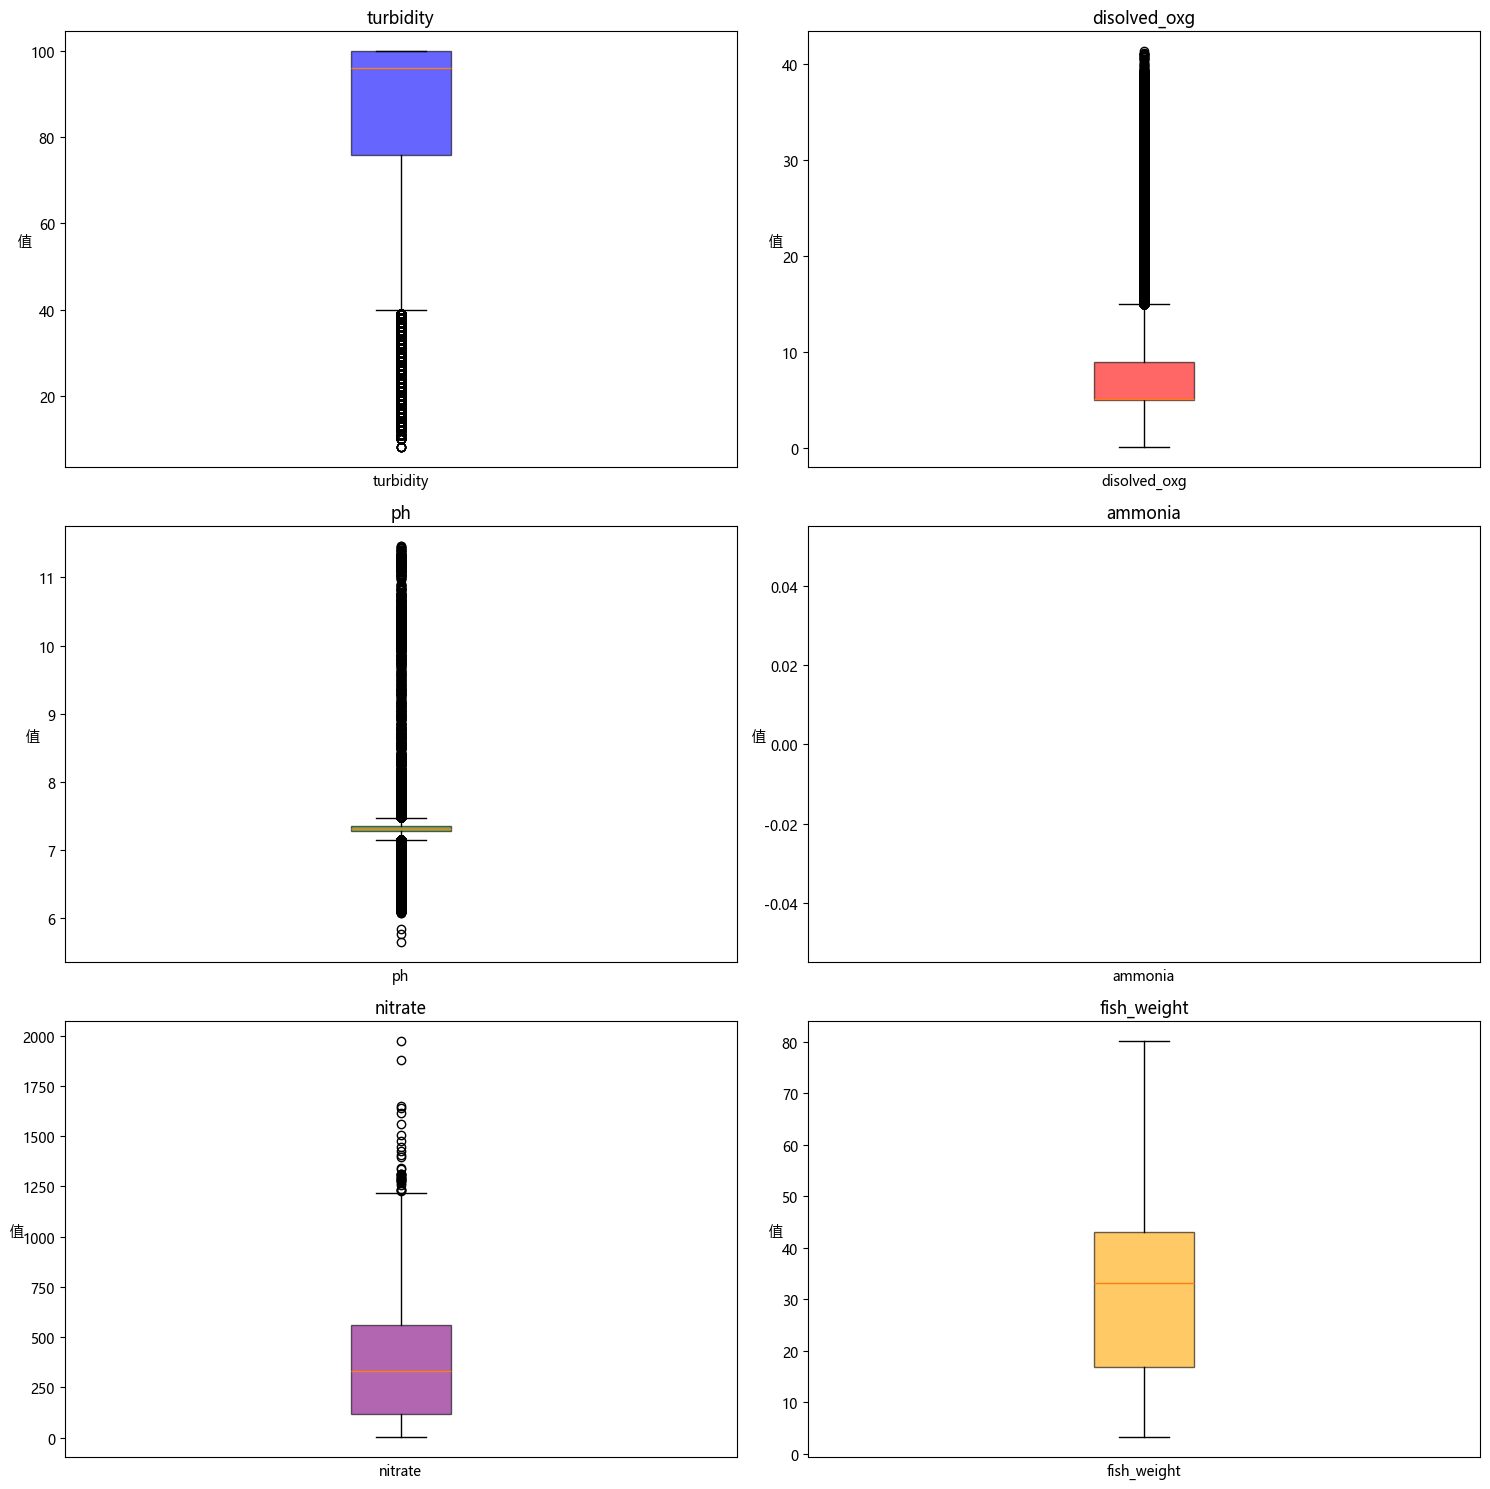

In [20]:
visualize_outliers(df) # bound_text=True

In [21]:
# 對 nitrate（硝酸鹽） 找出異常值並篩除。
Q1 = df['nitrate'].quantile(0.25)
Q3 = df['nitrate'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 找出異常值
outliers = df[(df['nitrate'] < lower_bound) | (df['nitrate'] > upper_bound)]
outliers = outliers.sort_values('nitrate')
print(f"異常值數量: {len(outliers)}")
outliers

異常值數量: 33


,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_weight
created_at,,,,,,
2021-07-01 17:10:30,98,17.208,10.04516,35.00443,1228,10.52
2021-07-01 18:29:33,97,0.515,11.35706,36.73597,1231,10.52
2021-07-01 18:36:23,97,4.581,11.11647,17.98907,1232,10.52
2021-07-01 23:17:44,97,2.814,7.76634,19.78313,1235,10.52
2021-07-31 13:57:12,100,5.080,7.36233,102.94199,1255,42.00
2021-07-31 14:01:24,100,2.097,7.33056,180.75375,1269,42.00
2021-07-31 13:57:31,100,5.080,7.37595,72.55155,1278,42.00
2021-07-01 20:13:36,96,16.498,8.14312,38.05461,1279,10.52
2021-08-09 11:09:46,100,5.080,7.53483,0.00418,1281,46.68


In [22]:
df = df[(df['nitrate'] >= lower_bound) & (df['nitrate'] <= upper_bound)]
df

,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_weight
created_at,,,,,,
2021-06-19 00:00:04,80,27.736,7.04911,5.15546,114,3.20
2021-06-19 00:00:26,80,4.195,7.09450,4.53072,114,3.20
2021-06-19 00:02:03,80,10.310,7.07635,5.21473,113,3.20
2021-06-19 00:02:26,81,1.196,7.07181,5.41747,100,3.20
2021-06-19 00:03:31,80,2.338,7.08996,5.45899,112,3.20
...,...,...,...,...,...,...
2021-08-18 22:03:11,100,5.080,7.21253,0.04318,844,80.14
2021-08-18 22:13:42,100,5.080,7.09450,0.04646,825,80.14
2021-08-18 22:17:44,100,5.080,7.11266,0.04219,800,80.14


In [23]:
# 填補其他欄位中有缺失值的行
for col in df.columns:
    
    # 1. 使用平均數(mean)來填補缺失值，避免直接刪除缺失值而損失過多數據。
    # 但是平均值可能無法反映數據的真實分佈。因此改用插值法（Interpolation）。
    # col_mean = df[col].mean()
    # df[col] = df[col].fillna(col_mean)

    # 2. 插值法的優點與
    # 1.) 能根據數據趨勢進行填補，避免平均值或中位數填補可能導致數據分佈失真的問題。
    # 2.) 對於連續的時間序列或數值型數據尤為有效。
    if df[col].isnull().any():  # 檢查列中是否有缺失值
        df[col] = df[col].interpolate(method='linear', limit_direction='forward', axis=0) # 指定插值方式為線性插值。

C:\Users\HoChePing\AppData\Local\Temp\ipykernel_260908\59365643.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].interpolate(method='linear', limit_direction='forward', axis=0) # 指定插值方式為線性插值。


<p> 對數據進行修正（Data Correction），處理數據中的異常值，將不合理的數據限制在一個合理的範圍內，避免極端值對分析或模型訓練造成負面影響。 </p>

In [24]:
#correcting data
# df['temperature'].loc[df['temperature'] < 20] = 20 # 將溫度低於 20 的值修正為 20，避免溫度過低可能導致分析錯誤。
df['ph'].loc[df['ph'] > 12] = 12  # 將 pH 值高於 12 的值修正為 12
df['ph'].loc[df['ph'] < 5] = 5  # 將 pH 值低於 5 的值修正為 5
df['ammonia'].loc[df['ammonia'] > 10] = 10 # 將氨濃度大於 10 的值修正為 10
df['nitrate'].loc[df['nitrate'] > 2000] = 2000 # 將硝酸鹽濃度大於 2000 的值修正為 2000

df

C:\Users\HoChePing\AppData\Local\Temp\ipykernel_260908\2332101225.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['ph'].loc[df['ph'] > 12] = 12  # 將 pH 值高於 12 的值修正為 12
C:\Users\HoChePing\AppData\Local\Temp\ipykernel_260908\2332101225.

,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_weight
created_at,,,,,,
2021-06-19 00:00:04,80,27.736,7.04911,5.15546,114,3.20
2021-06-19 00:00:26,80,4.195,7.09450,4.53072,114,3.20
2021-06-19 00:02:03,80,10.310,7.07635,5.21473,113,3.20
2021-06-19 00:02:26,81,1.196,7.07181,5.41747,100,3.20
2021-06-19 00:03:31,80,2.338,7.08996,5.45899,112,3.20
...,...,...,...,...,...,...
2021-08-18 22:03:11,100,5.080,7.21253,0.04318,844,80.14
2021-08-18 22:13:42,100,5.080,7.09450,0.04646,825,80.14
2021-08-18 22:17:44,100,5.080,7.11266,0.04219,800,80.14


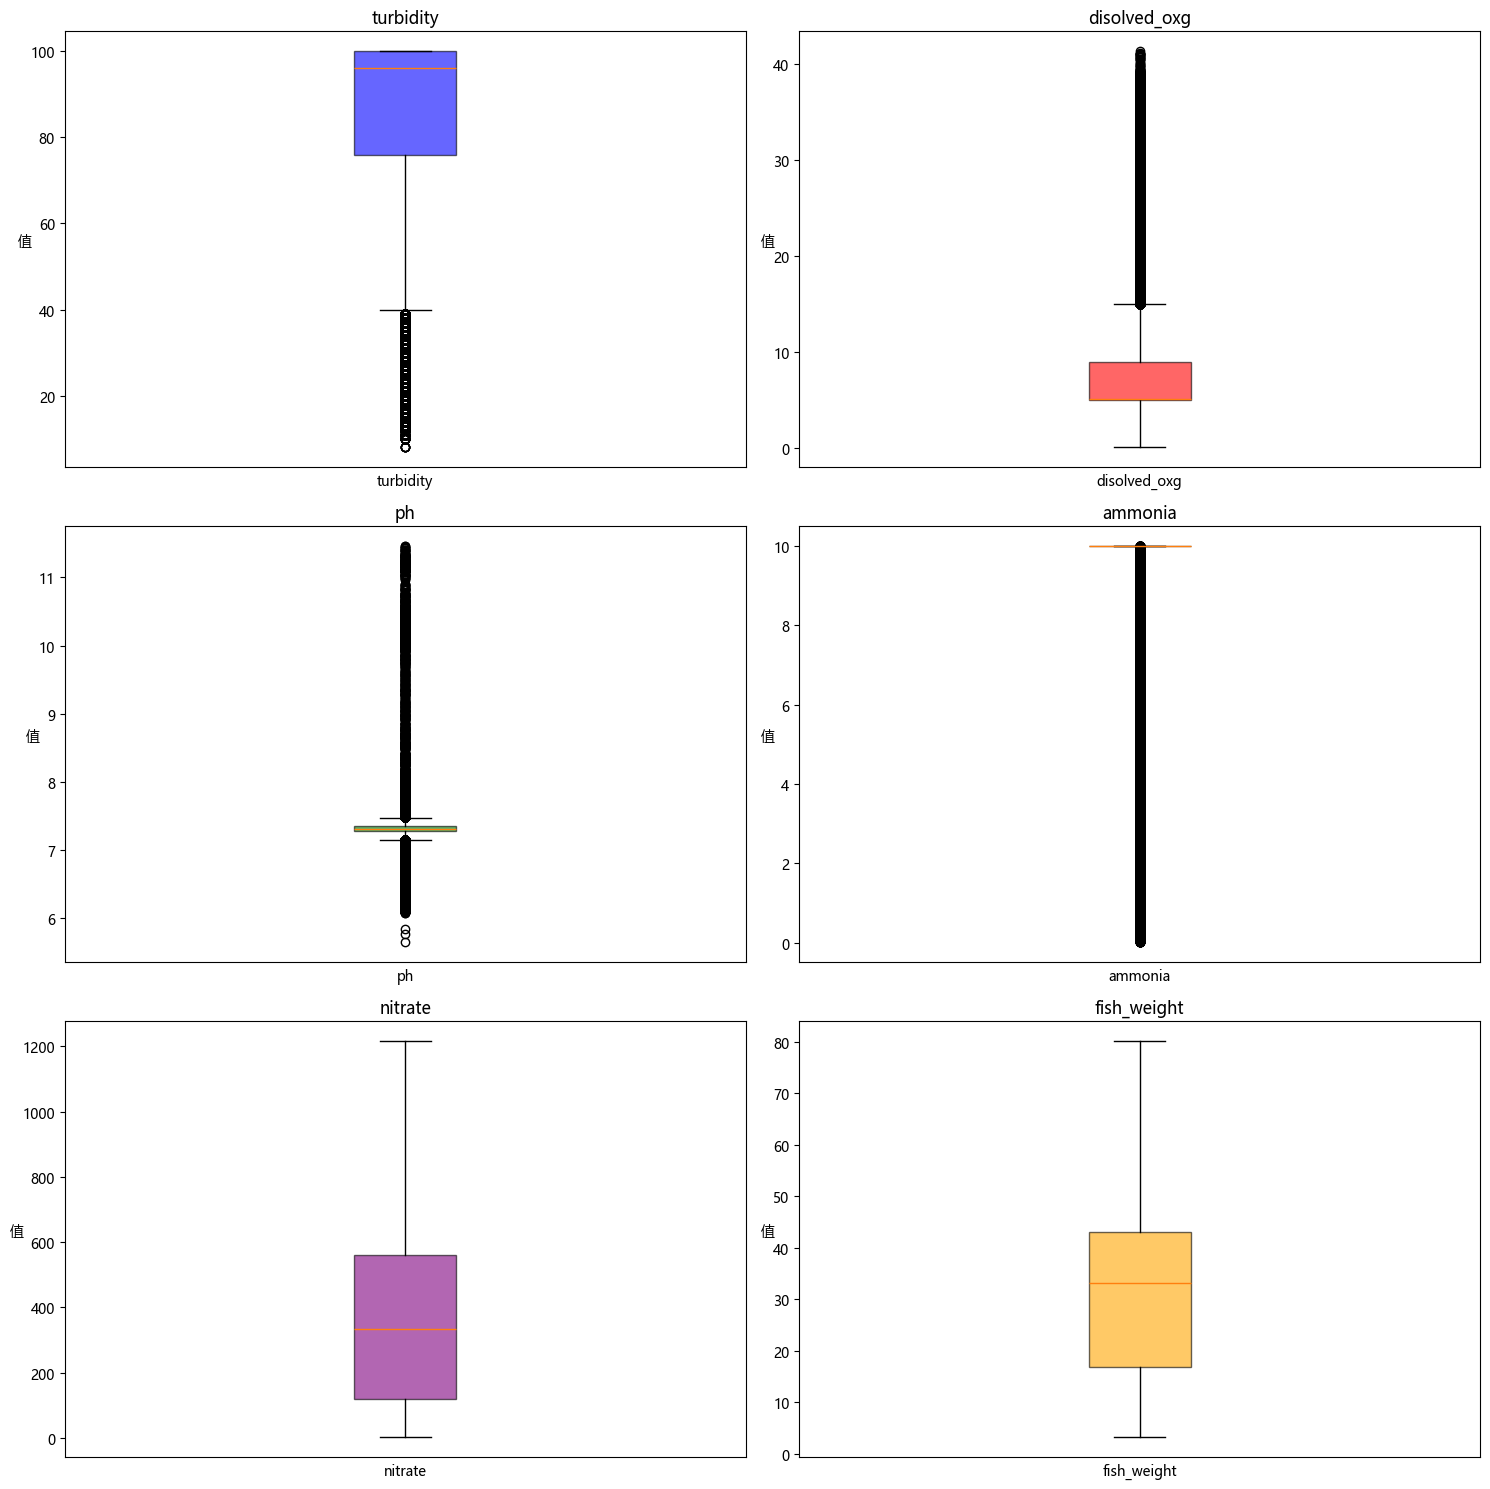

In [25]:
visualize_outliers(df) # bound_text=True

<p> Fish Length為6.74應該是屬於正常值，為第一天測量的記錄。  </p>

<p> 再次檢查是否有缺失值。 </p>

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 152327 entries, 2021-06-19 00:00:04 to 2021-08-18 22:28:21
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   turbidity     152327 non-null  int64  
 1   disolved_oxg  152327 non-null  float64
 2   ph            152327 non-null  float64
 3   ammonia       152327 non-null  float64
 4   nitrate       152327 non-null  int64  
 5   fish_weight   152327 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 8.1 MB


In [27]:
# checking null values in our dataset
df.isna().sum()

turbidity       0
disolved_oxg    0
ph              0
ammonia         0
nitrate         0
fish_weight     0
dtype: int64

<h3 style='color:blue'> 下採樣（aggregating data）與聚合 </h3>

<ol> Note: 為什麼要使用下採樣？
    <li> 研究方向是水樣品質與魚的重量和長度的關係，而魚的重量和長度的變化通常是隨著時間逐漸累積的。它可能不會受到幾秒鐘內水質變化的影響，而是更可能受到數小時或數天內的水質趨勢影響。 </li>
    <li> 每 5 秒鐘記錄一次，數據非常密集，可能導致計算資源不足，且模型可能無法有效處理這麼大的窗口。 </li>
    <li> 為了處理頻繁的記錄，可以對數據進行下採樣（aggregating data），例如每 1 分鐘取一次平均值或特徵值，從而降低數據密度。 </li>
    <li> 下採樣數據 是處理高頻數據的關鍵步驟，可顯著減少計算負擔。 </li>
</ol>

<p style='color:purple'> 備註：原本資料集是以每5秒鐘記錄水樣品質( The datasets are generated automatically at 5 seconds intervals using the following water quality sensors driven by the ESP 32 microcontroller) </p>

<ol> Note: 先處理異常值與缺失值，再進行下採樣的優點
    <li> 特徵值中的極端值可能拉高或拉低平均值，從而影響後續的分析。 </li>
    <li> 遇到異常值或缺失值時，直接下採樣可能導致聚合結果偏離真實數據特徵。反過來說，先處理異常值（如剪裁到合理範圍）可以提高聚合的準確性。 </li>
    <li> 可以更精確地補值或修正異常值，然後進行聚合。 </li>
    <li> 在原始數據上處理異常值和缺失值，可以根據具體情況選擇替換策略，而不被聚合的結果約束。 </li>
</ol>

In [ ]:
# df[::20] # 看是否需要跳號

↑ df[::20] # 看是否需要跳號

<ol> 不合理！
    <li> 如果數據的時間分佈並不均勻，直接跳號可能導致數據失去代表性。 </li>
    <li> 這種方式忽略了時間窗口的特性，可能導致丟失重要的信息。 </li>
</ol>

In [28]:
# 將數據從 每5秒 下採樣為 每分鐘（取平均值）
df = df.resample('1Min').mean() # 每分鐘聚合數據

# 空值是由於聚合後的時間窗口內完全沒有數據，因此可以適用刪除空值。
df.dropna(inplace=True) # 這些空值是由於聚合期間完全沒有數據導致的，刪除這些空值是合理的。且不會對模型訓練提供任何有用的資訊。
df

,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_weight
created_at,,,,,,
2021-06-19 00:00:00,80.0,15.9655,7.071805,4.84309,114.0,3.20
2021-06-19 00:02:00,80.5,5.7530,7.074080,5.31610,106.5,3.20
2021-06-19 00:03:00,80.0,2.3380,7.089960,5.45899,112.0,3.20
2021-06-19 00:04:00,80.0,20.3890,7.076350,5.41747,112.0,3.20
2021-06-19 00:05:00,80.0,4.1770,7.076350,5.41747,113.0,3.20
...,...,...,...,...,...,...
2021-08-18 22:03:00,100.0,5.0800,7.212530,0.04318,844.0,80.14
2021-08-18 22:13:00,100.0,5.0800,7.094500,0.04646,825.0,80.14
2021-08-18 22:17:00,100.0,5.0800,7.112660,0.04219,800.0,80.14


In [29]:
# 檢查是否有成功填補缺失值或異常值。
df.to_csv('IoTPond3 Test.csv')

<h3> 畫出視覺化數據 </h3>

<p> 查看統計資料 </p>

In [30]:
#敘述統計
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
turbidity,63160.0,80.987439,27.958058,8.000000,73.666667,96.000000,100.000000,100.000000
disolved_oxg,63160.0,7.888045,5.954625,0.008000,4.620917,5.080000,9.563625,39.716000
ph,63160.0,7.295582,0.278516,5.947533,7.283647,7.312400,7.345687,11.440283
ammonia,63160.0,8.384602,3.223091,0.005860,9.894763,10.000000,10.000000,10.000000
nitrate,63160.0,353.625620,253.736184,9.000000,119.666667,289.666667,562.333333,1195.000000
fish_weight,63160.0,30.398666,16.602553,3.200000,16.820000,33.160000,43.040000,80.140000


<p> 儲存可視化數據圖表 </p>

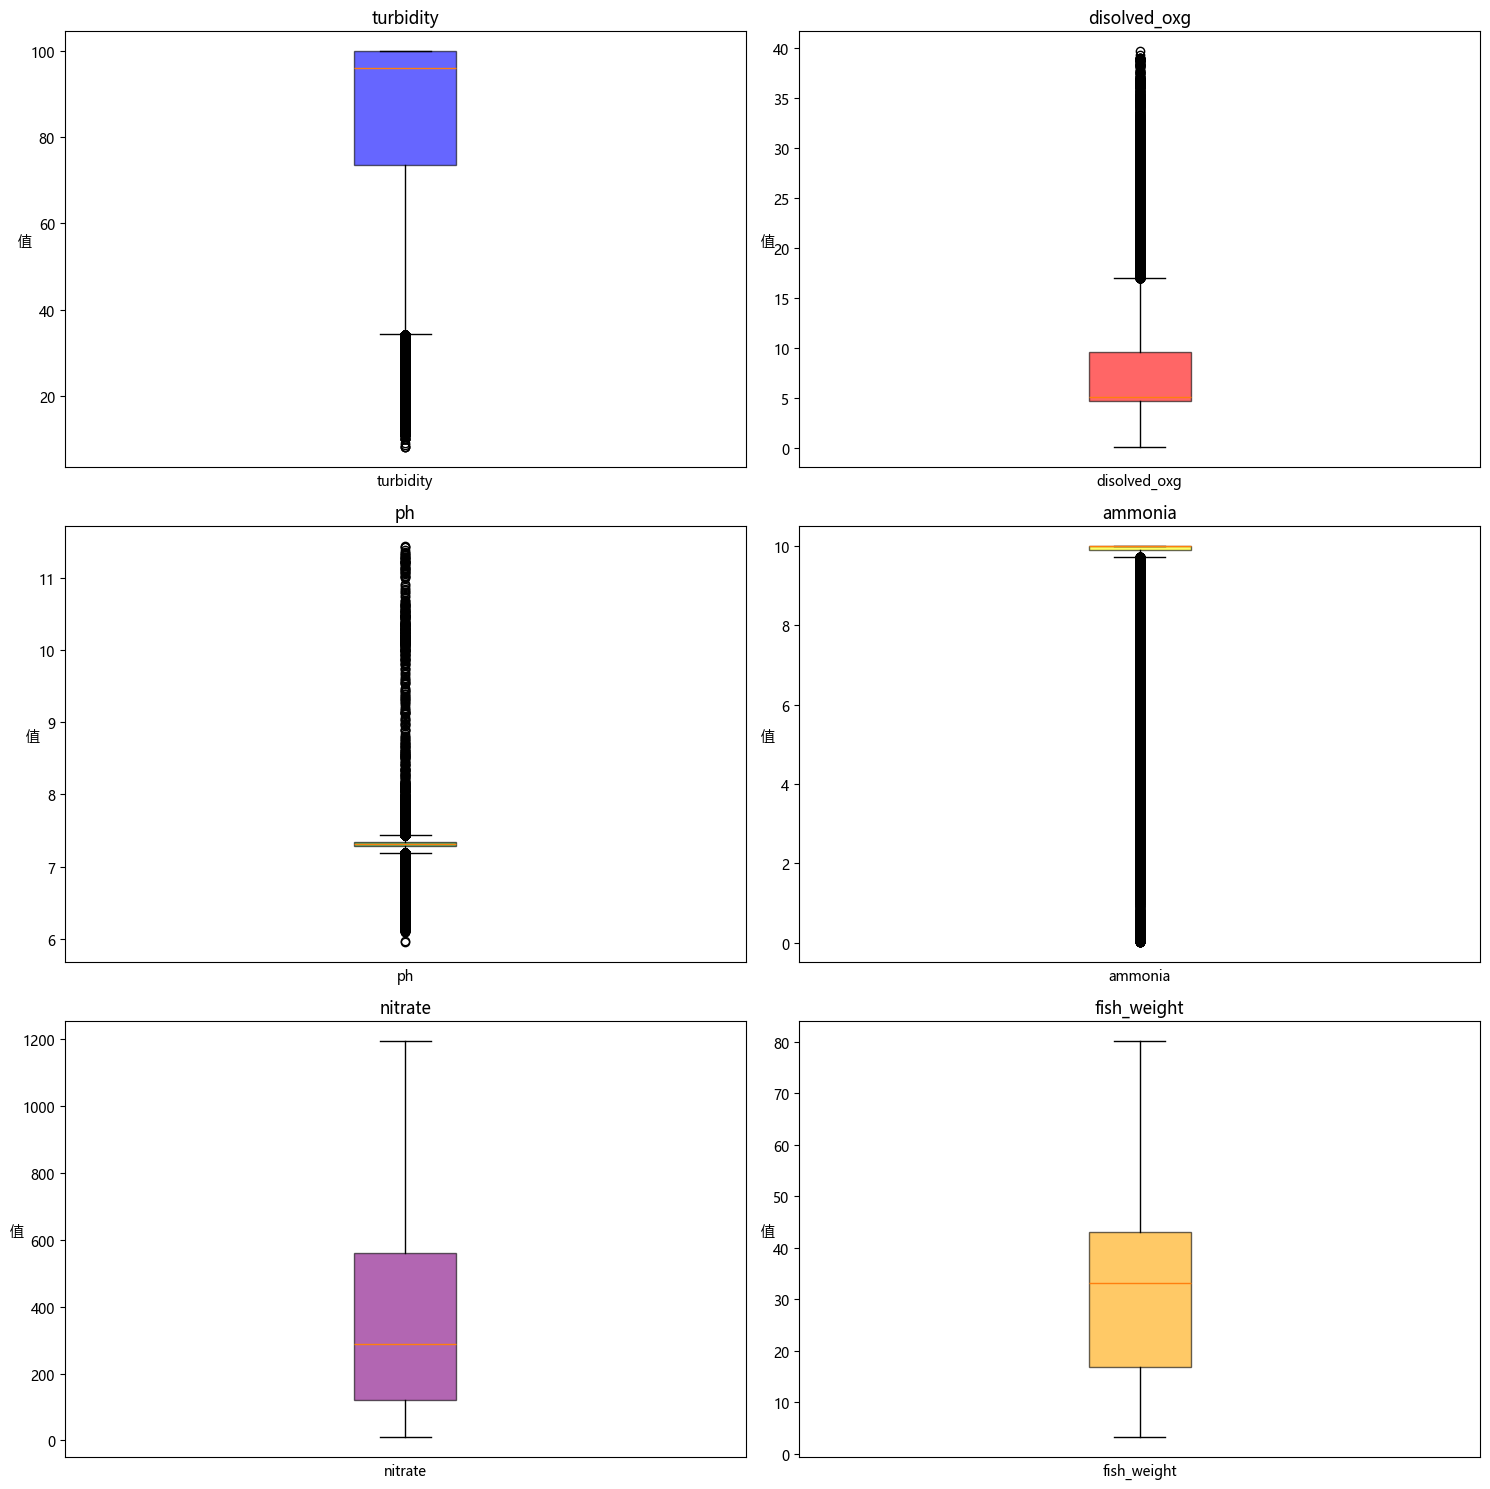

In [31]:
# 使用 箱線圖 來檢查特徵中的異常值。
visualize_outliers(df, save=True)

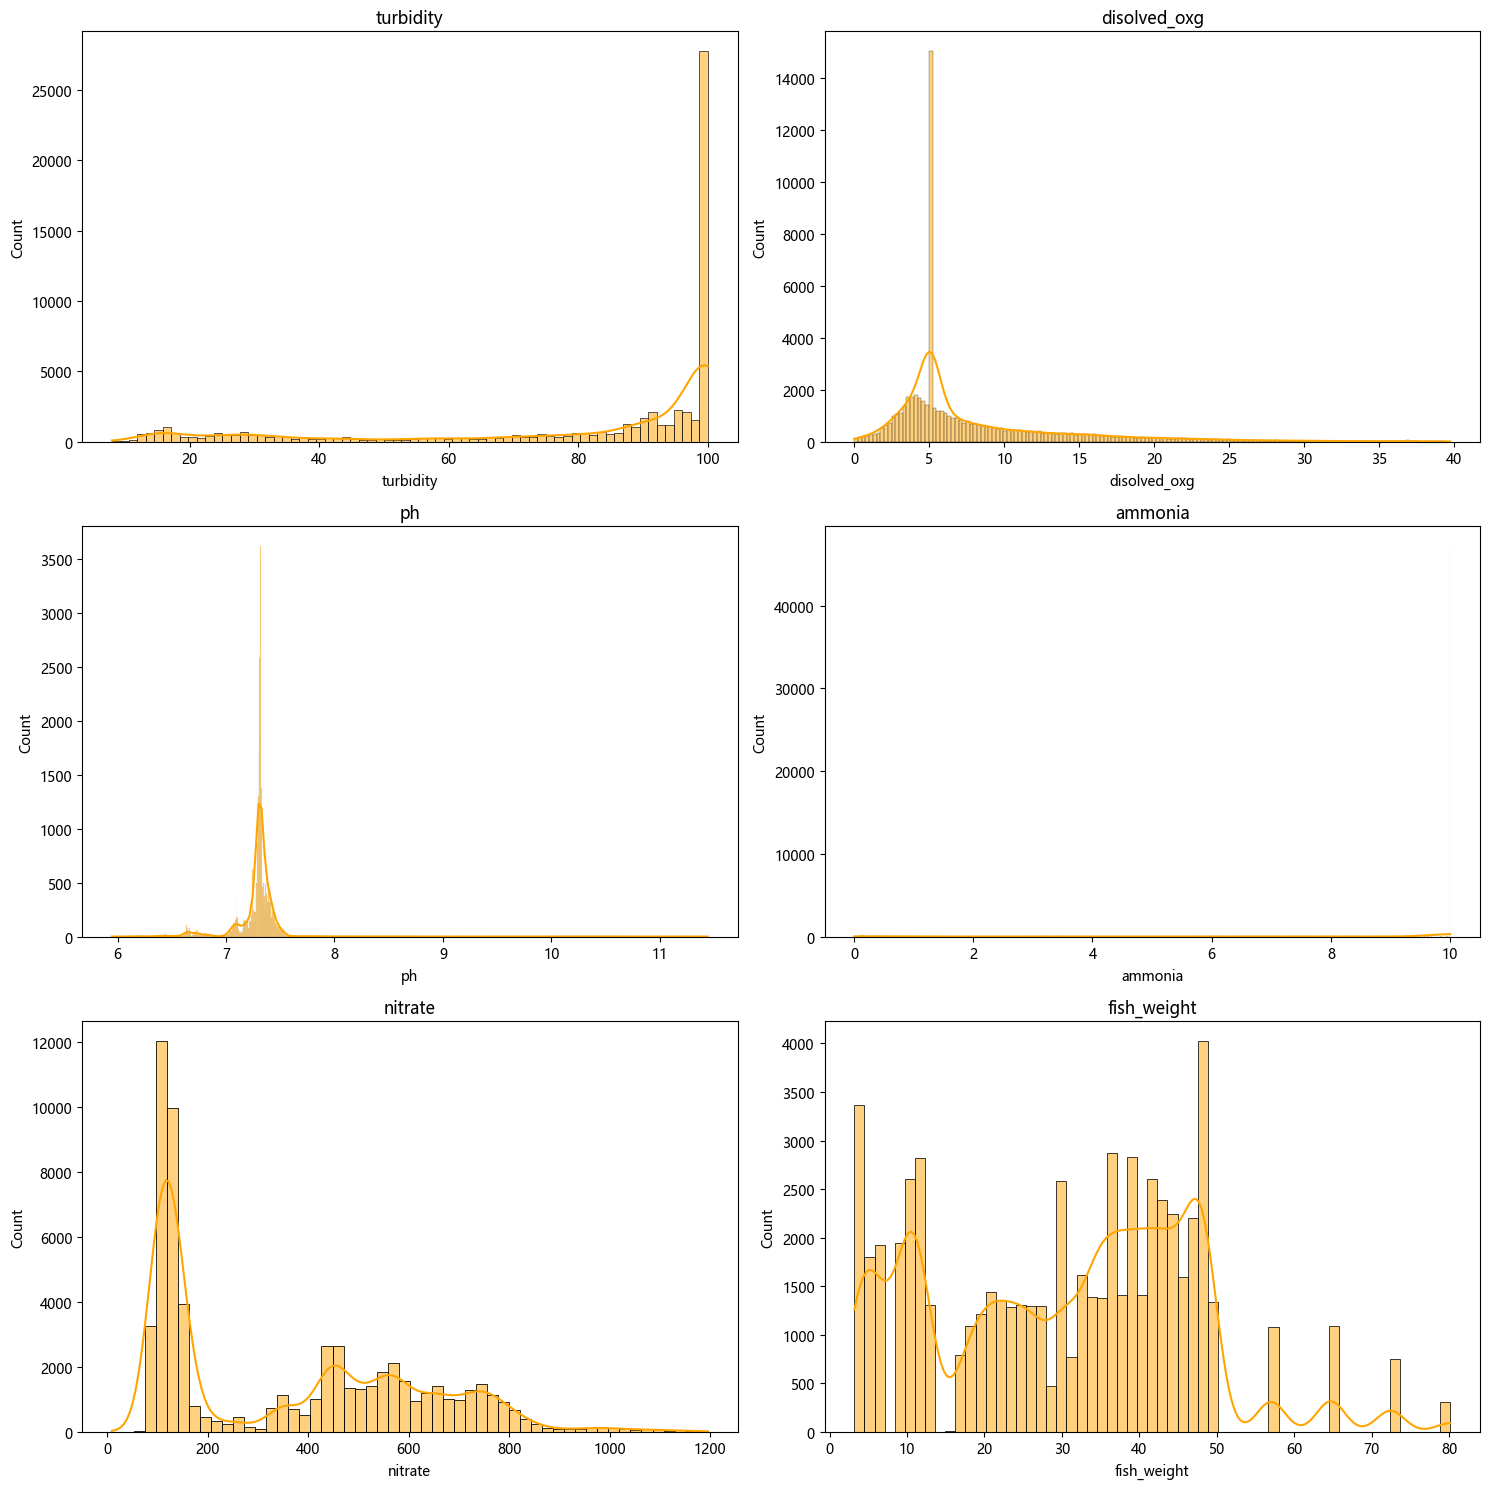

In [32]:
# 使用 分佈圖 來檢查特徵中的異常值。
visualize_distributions(df, save=True)

<ol> 直方圖（Histogram）：
    <li> 橙色部分：展示了特徵數據的分佈情況。（每個區間內的數據量） </li>
    <li> 橙色曲線：核密度估計，用於平滑數據分佈，幫助我們了解數據的大致趨勢和分佈形狀。 </li>
</ol>

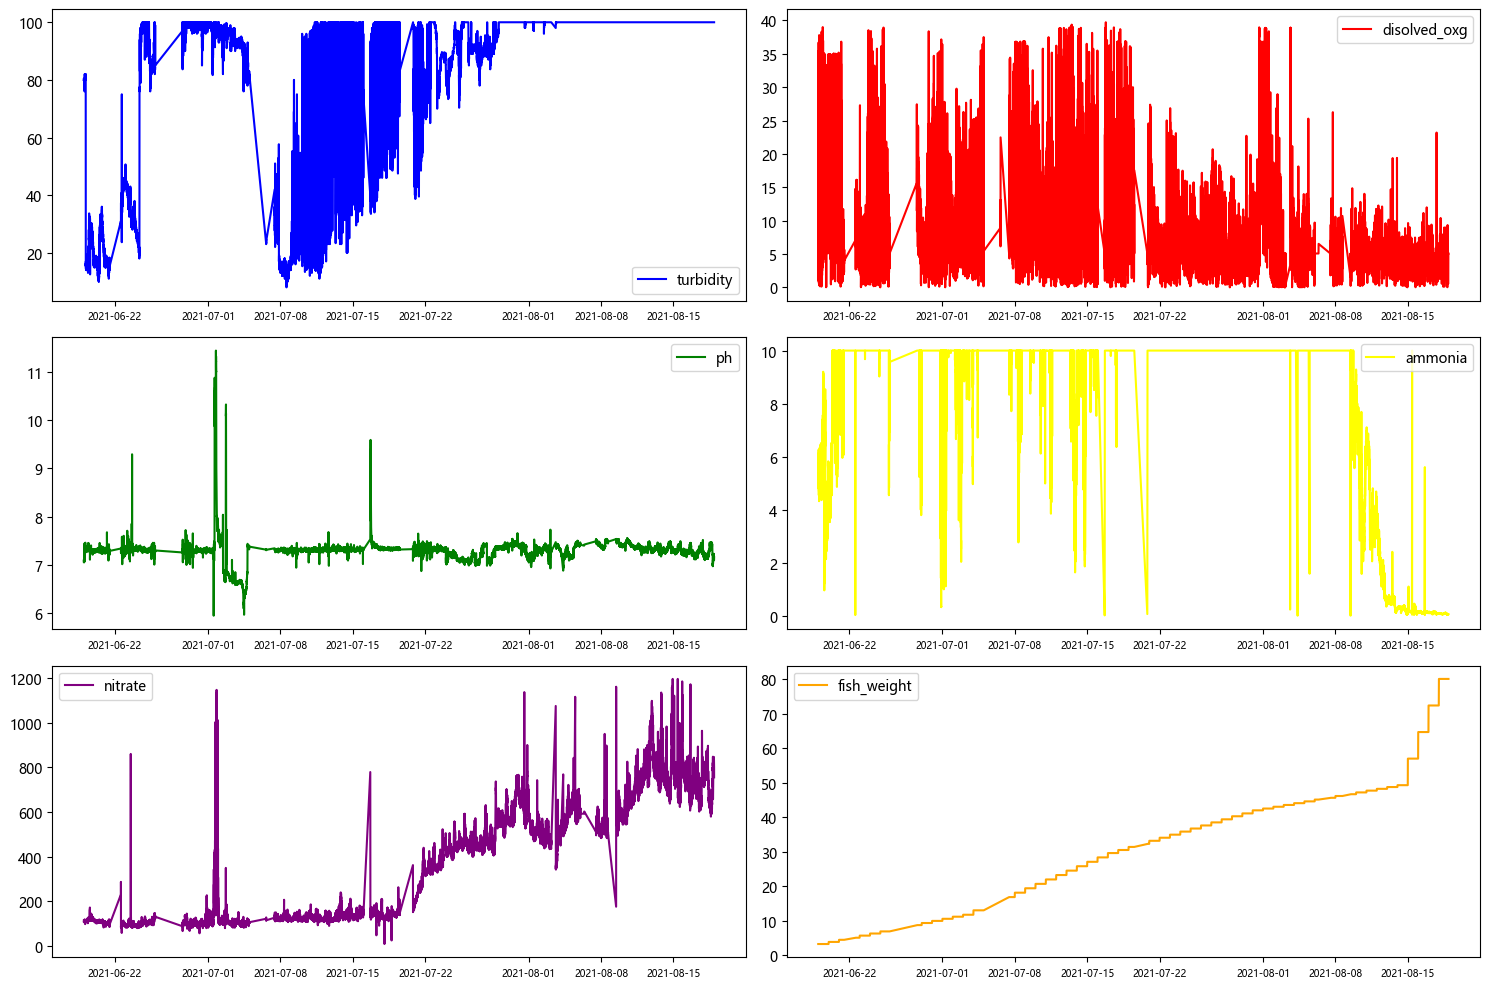

In [33]:
#visualizing a dataframe
# 將多個特徵（列）的數據繪製成子圖，並基於提供的日期時間索引進行繪製。
visualize_df(df, df.index, save=True)

<p> 針對fish_weight魚的重量特別繪製！ </p>

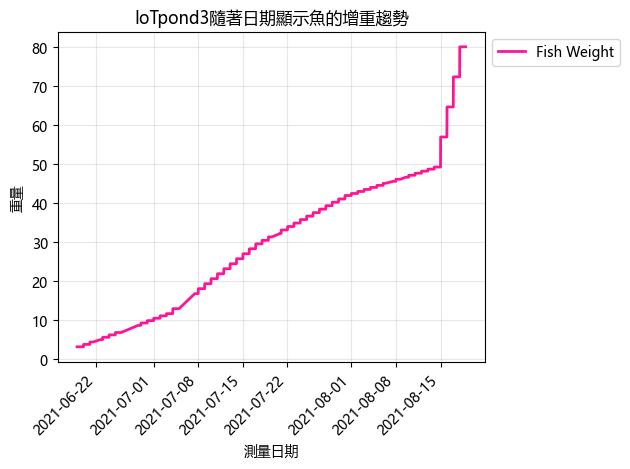

In [34]:
plt.plot(df.index, df['fish_weight'], color='deeppink', linewidth=2, label='Fish Weight')

# 设置图表标题和标签
plt.title('IoTpond3隨著日期顯示魚的增重趨勢')

# 修正 x 軸
plt.gcf().autofmt_xdate()  # 自動調整日期格式和角度
plt.xticks(rotation=45)    # 將 x 軸標籤旋轉 45 度以避免重疊
plt.xlabel('測量日期')

plt.ylabel('重量')
plt.legend(loc='best', bbox_to_anchor=(1, 1))  # Moves the legend outside the plot
plt.grid(True, alpha=0.3)  # 显示网格
plt.xticks()  # 日期标签旋转，便于阅读 #rotation=45

# 显示图形
plt.tight_layout()
plt.savefig('feature/IoTpond3 Fish Weight Growth Trend.png', bbox_inches='tight') # 儲存圖表，並且自動調整圖表的邊界，去除多餘的空白區域。
plt.show()


<h3> 證明為什麼fish_weight適合作為預測目標 </h3>

<p> Find correlations between attributes </p>

In [35]:
# using pearson's correlation to find the correlation between all the features
# population 列中的所有數值都相同，全為50，相關性無法計算，因此結果為 NaN。
df.corr()

,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_weight
turbidity,1.000000,-0.383352,-0.004995,-0.181439,0.536061,0.529181
disolved_oxg,-0.383352,1.000000,-0.006068,0.158303,-0.340254,-0.273123
ph,-0.004995,-0.006068,1.000000,-0.040706,0.110108,0.060262
ammonia,-0.181439,0.158303,-0.040706,1.000000,-0.587223,-0.487394
nitrate,0.536061,-0.340254,0.110108,-0.587223,1.000000,0.874127
fish_weight,0.529181,-0.273123,0.060262,-0.487394,0.874127,1.000000


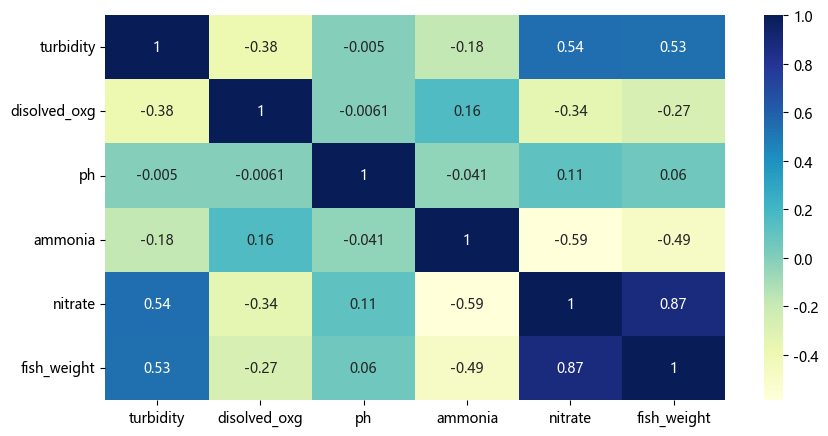

In [36]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True)
plt.savefig('feature/IoTpond3 Pearson Correlation.png', bbox_inches='tight') # 儲存圖表，並且自動調整圖表的邊界，去除多餘的空白區域。
plt.show()

In [37]:
df.corr()['fish_weight']

turbidity       0.529181
disolved_oxg   -0.273123
ph              0.060262
ammonia        -0.487394
nitrate         0.874127
fish_weight     1.000000
Name: fish_weight, dtype: float64

<p> 線性回歸、Lasso 和 Ridge 都是靜態模型，它們假設特徵與目標變數之間是靜態線性關係。 </p>
<p> 靜態回歸模型（如線性回歸、Lasso、Ridge）對於時間依賴性較差，尤其在分佈不平穩時。 </p>
<br>
<p> 而時間序列中的趨勢可能是動態的、非線性的。 </p>
<p> 當時間序列分佈改變時，這些靜態模型無法有效捕捉時間依賴性，導致性能下降。 </p>

In [38]:
def solve(X,y):

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=1)
    
    # using linear regression (使用 普通線性回歸 方法對訓練數據進行建模。)
    # 找到一條直線，使得該直線可以最好地解釋特徵與目標值之間的線性關係。
    model = LinearRegression()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("R2_score of Linear Regression:",r2_score(y_test,y_pred))

    # using Lasso regression (L1 正則化項)
    # Lasso 回歸會對不重要的特徵執行特徵選擇（即將某些權重變為 0），以減少過擬合。
    # 自動選擇重要特徵，並且能有效處理高維數據，提升模型的可解釋性。
    model = Lasso(alpha=0.1)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("R2_score of Lasso Regression:",r2_score(y_test,y_pred))

    # using Ridge regression ( L2 正則化項)
    # Ridge 回歸會對所有權重施加懲罰，但不會將它們變為 0，適合處理多重共線性問題。
    model = Ridge(alpha=0.1)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("R2_score of Ridge Regression:",r2_score(y_test,y_pred))

In [39]:
X = df[ ['turbidity', 'disolved_oxg', 'ph', 'ammonia', 'nitrate'] ]
y = df['fish_weight']

In [40]:
# R² 分數（決定係數，Coefficient of Determination）是一個評估回歸模型性能的指標，用於衡量模型對於數據變異的解釋能力。
# R²=1：模型完美解釋數據。
# R²=0：模型與目標值沒有關係。
# R²<0：模型比隨機猜測更糟糕。
solve(X,y)

R2_score of Linear Regression: 0.7700117310076008
R2_score of Lasso Regression: 0.7696674368317806
R2_score of Ridge Regression: 0.7700117338546969


<p> Reference: How to approach a dataset (EDA)- Learn With Me 如何使用資料集 （EDA）  </p>
https://www.kaggle.com/code/prakharjadaun/how-to-approach-a-dataset-eda-learn-with-me

<h3> Normalize (min-max-scaler) </h3>
<ol> Note:為什麼使用min-max-scaler
    <li> 保留數據分佈的形狀。 </li>
    <li> Fish Weight是遞增型數據，推薦使用MinMaxScaler。 </li>
    <li> 模型是LSTM，使用MinMaxScaler，將數據縮放到[0, 1] 範圍內，助於加快模型收斂速度。。 </li>
</ol>

In [41]:
normalizer = MinMaxScaler() # 將數據縮放到一個固定範圍內（例如 [0, 1]）。
df[df.columns.tolist()] = normalizer.fit_transform(df[df.columns.tolist()]) # 第一步：正規化數據
df

,turbidity,disolved_oxg,ph,ammonia,nitrate,fish_weight
created_at,,,,,,
2021-06-19 00:00:00,0.782609,0.401871,0.204683,0.484007,0.088533,0.0
2021-06-19 00:02:00,0.788043,0.144681,0.205097,0.531335,0.082209,0.0
2021-06-19 00:03:00,0.782609,0.058678,0.207988,0.545633,0.086847,0.0
2021-06-19 00:04:00,0.782609,0.513272,0.205510,0.541478,0.086847,0.0
2021-06-19 00:05:00,0.782609,0.104991,0.205510,0.541478,0.087690,0.0
...,...,...,...,...,...,...
2021-08-18 22:03:00,1.000000,0.127732,0.230303,0.003734,0.704047,1.0
2021-08-18 22:13:00,1.000000,0.127732,0.208815,0.004062,0.688027,1.0
2021-08-18 22:17:00,1.000000,0.127732,0.212121,0.003635,0.666948,1.0


<p> save dataset </p>

In [42]:
y = df['fish_weight'].values
pd.DataFrame(y, columns=['fish_weight'], index=df.index)

,fish_weight
created_at,
2021-06-19 00:00:00,0.0
2021-06-19 00:02:00,0.0
2021-06-19 00:03:00,0.0
2021-06-19 00:04:00,0.0
2021-06-19 00:05:00,0.0
...,...
2021-08-18 22:03:00,1.0
2021-08-18 22:13:00,1.0
2021-08-18 22:17:00,1.0


In [43]:
X = df.drop(['fish_weight'], axis=1).values
pd.DataFrame(X, columns=df.columns[:-1], index=df.index)

,turbidity,disolved_oxg,ph,ammonia,nitrate
created_at,,,,,
2021-06-19 00:00:00,0.782609,0.401871,0.204683,0.484007,0.088533
2021-06-19 00:02:00,0.788043,0.144681,0.205097,0.531335,0.082209
2021-06-19 00:03:00,0.782609,0.058678,0.207988,0.545633,0.086847
2021-06-19 00:04:00,0.782609,0.513272,0.205510,0.541478,0.086847
2021-06-19 00:05:00,0.782609,0.104991,0.205510,0.541478,0.087690
...,...,...,...,...,...
2021-08-18 22:03:00,1.000000,0.127732,0.230303,0.003734,0.704047
2021-08-18 22:13:00,1.000000,0.127732,0.208815,0.004062,0.688027
2021-08-18 22:17:00,1.000000,0.127732,0.212121,0.003635,0.666948


In [44]:
# 取前面80%為train，後面20%為test。
data_dic = {'X_train':X[:int(X.shape[0]*0.8)],
            'y_train':y[:int(X.shape[0]*0.8)],
            'X_test':X[int(y.shape[0]*0.8):],
            'y_test':y[int(y.shape[0]*0.8):]}

data_dic

{'X_train': array([[0.7826087 , 0.40187116, 0.20468284, 0.48400663, 0.08853288],
        [0.78804348, 0.14468117, 0.20509702, 0.53133536, 0.08220911],
        [0.7826087 , 0.05867835, 0.20798811, 0.54563274, 0.08684654],
        ...,
        [1.        , 0.13517427, 0.2633611 , 1.        , 0.5143339 ],
        [1.        , 0.12247742, 0.26473867, 1.        , 0.50646431],
        [1.        , 0.17803297, 0.2652897 , 1.        , 0.51152333]]),
 'y_train': array([0.        , 0.        , 0.        , ..., 0.53808162, 0.53808162,
        0.53808162]),
 'X_test': array([[1.        , 0.08770693, 0.26776873, 1.        , 0.50927487],
        [1.        , 0.12773245, 0.26611624, 1.        , 0.49747049],
        [1.        , 0.14907995, 0.26887078, 1.        , 0.5019674 ],
        ...,
        [1.        , 0.12773245, 0.21212083, 0.00363513, 0.66694772],
        [1.        , 0.12773245, 0.21873318, 0.0049559 , 0.66694772],
        [1.        , 0.12773245, 0.22038627, 0.00523507, 0.62900506]]),
 'y

In [45]:
# 儲存為pkl檔案
# pkl檔案 用於儲存 Python 資料結構。
for key,value in data_dic.items():
    with open(f'{key}.pkl','wb') as f: # 使用 pickle.dump 將數據寫入文件，'wb' 表示二進制寫入。
        pickle.dump(value, f)

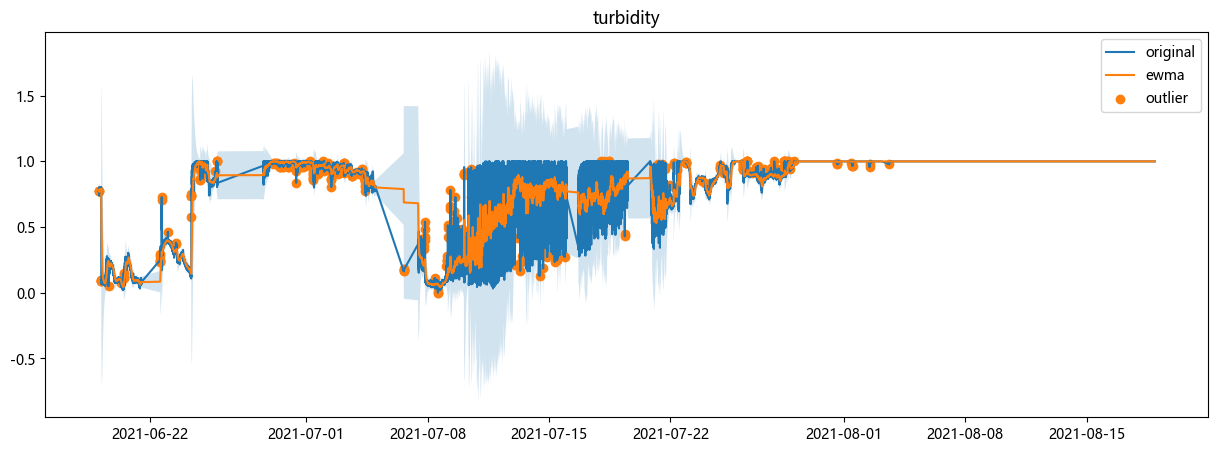

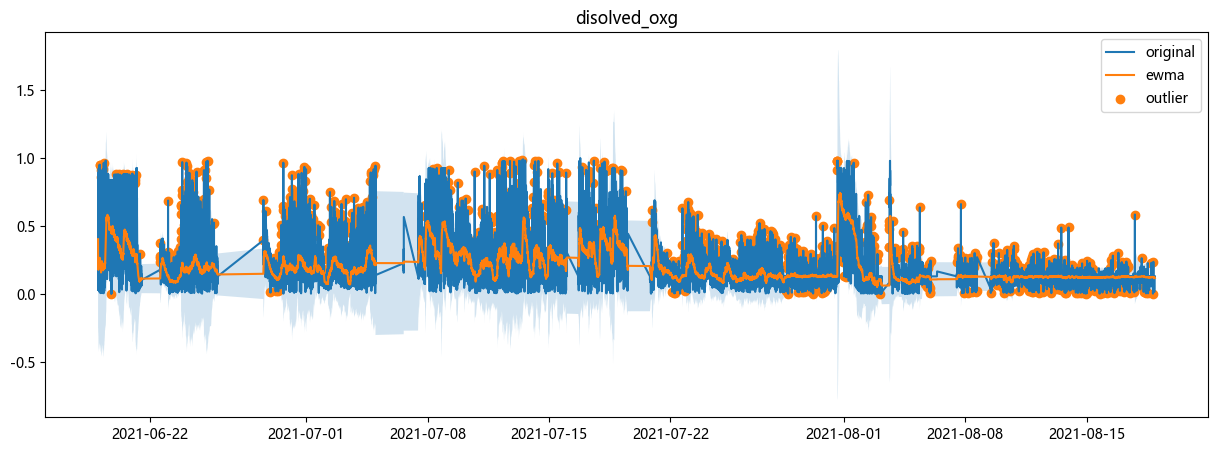

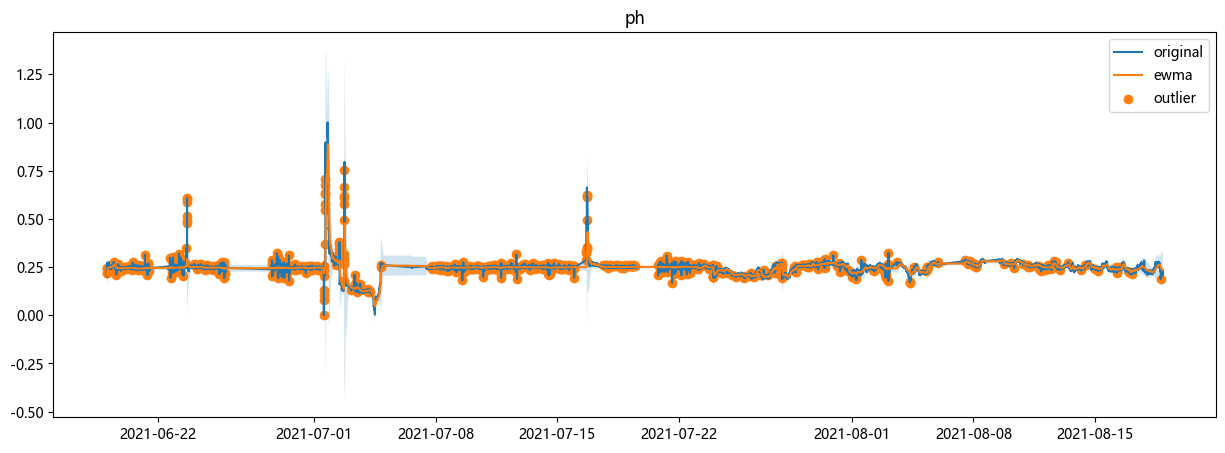

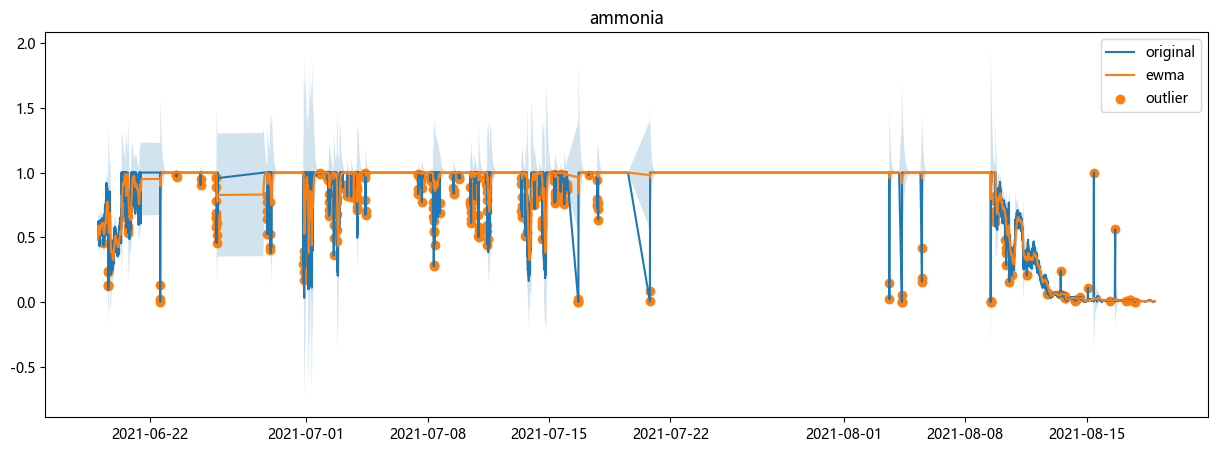

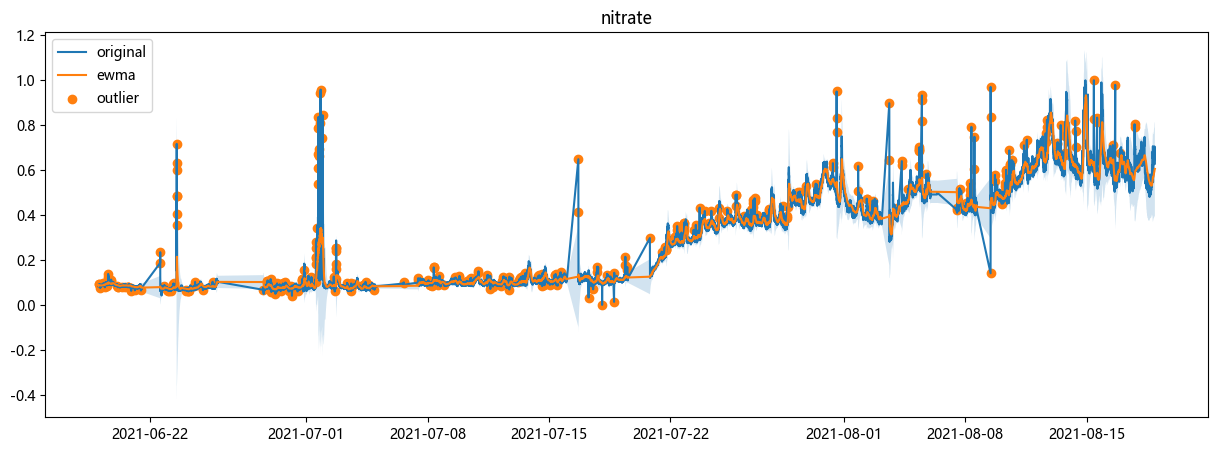

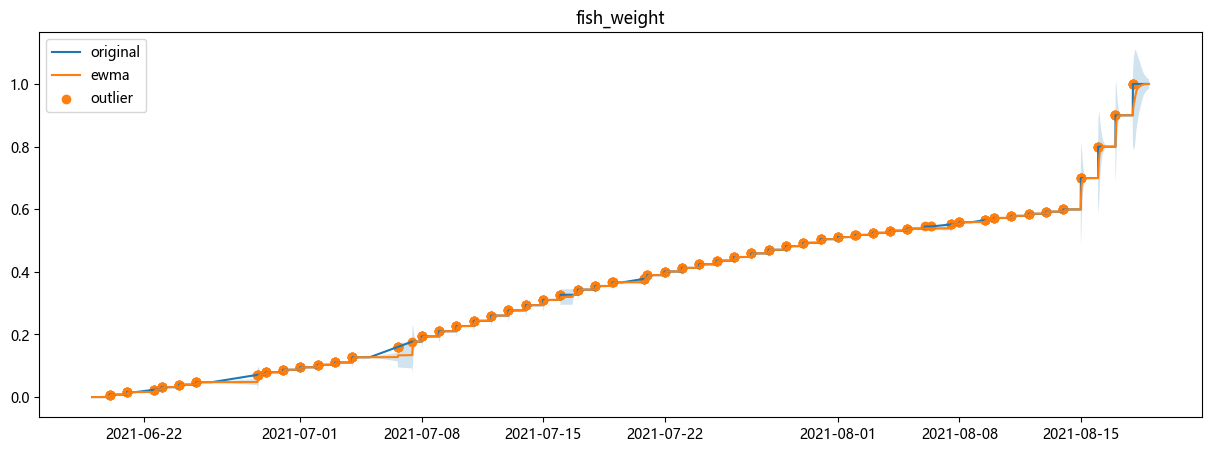

In [46]:
# save feature plot 
for n_column in df.columns:
    plot_outlier(df[n_column], n_column, save=True)

<p> Reference: Aquaponics Dataset Forecasting: Model Comparison </p>
https://www.kaggle.com/code/hocheping/aquaponics-dataset-forecasting-model-comparison/edit

<p> Reference:Aquaponics-Fish-Pond-Datasets-Forecasting-Model</p>
https://www.kaggle.com/code/hocheping/aquaponics-fish-pond-datasets-forecasting-model/edit